<a href="https://colab.research.google.com/github/EfandraEka/PREDICTION-MENTAL-HEALTH/blob/main/PERCOBAAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile, pandas as pd, numpy as np, os
from pathlib import Path

uploaded = files.upload()  # upload Mental-health-tables-National.zip
zip_name = list(uploaded.keys())[0]
Path("data").mkdir(exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall("data")

print("Extracted files:")
for f in os.listdir("data"):
    print("-", f)

Saving Mental-health-tables-National.zip to Mental-health-tables-National.zip
Extracted files:
- Table 14 - Aspects of disordered eating.xlsx
- Table 15 - Social connectedness and self-management strategies for mental health.xlsx
- Table 1 - Lifetime mental disorders by sex.xlsx
- Table 9 - Suicidal thoughts and behaviours by age and sex.xlsx
- Table 11 - Self-harm behaviours by age and sex.xlsx
- Table 6 - Consultations with health professionals for mental health by age and sex.xlsx
- Table 5 - 12-month mental disorder groups by selected health characteristics.xlsx
- Table 13 - Perceived need for help for people who did not consult a health professional.xlsx
- Table 7 - Other services for mental health accessed via digital technologies by age and sex.xlsx
- Table 16 - Psychological distress.xlsx
- Table 10 - Whether close to someone who took or attempted to take own life by age and sex.xlsx
- Table 3 - 12-month disorder groups by age and sex.xlsx
- Table 8 - Comorbidity of 12-month me

In [2]:
def load_any_dataset(folder):
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        try:
            if f.endswith('.csv'):
                df = pd.read_csv(path)
            elif f.endswith('.xlsx') or f.endswith('.xls'):
                df = pd.read_excel(path)
            else:
                continue
            if df.shape[0] > 50 and df.shape[1] > 4:
                print(" Loaded dataset:", f)
                return df
        except Exception:
            pass
    return None

df = load_any_dataset("data")
if df is None:
    print("Tidak ditemukan data individu, membuat data sintetis...")

    np.random.seed(42)
    N = 4000
    df = pd.DataFrame({
        'age': np.random.randint(18, 80, N),
        'sex': np.random.choice(['Male', 'Female'], N),
        'phq9_score': np.clip(np.random.normal(10, 5, N), 0, 27),
        'on_antidepressant': np.random.binomial(1, 0.15, N),
        'comorbidity_count': np.random.poisson(1, N)
    })

Tidak ditemukan data individu, membuat data sintetis...


In [3]:
def categorize_depression(score):
    if score <= 4: return 'none'
    elif score <= 9: return 'mild'
    elif score <= 14: return 'moderate'
    else: return 'severe'

df['depression_level'] = df['phq9_score'].apply(categorize_depression)
print(df['depression_level'].value_counts())
df.head()

depression_level
moderate    1412
mild        1269
severe       831
none         488
Name: count, dtype: int64


,age,sex,phq9_score,on_antidepressant,comorbidity_count,depression_level
0,56,Female,13.317239,0,0,moderate
1,69,Female,6.378767,1,0,mild
2,46,Female,12.931665,0,1,moderate
3,32,Male,8.019370,0,0,mild
4,60,Female,7.734471,0,0,mild


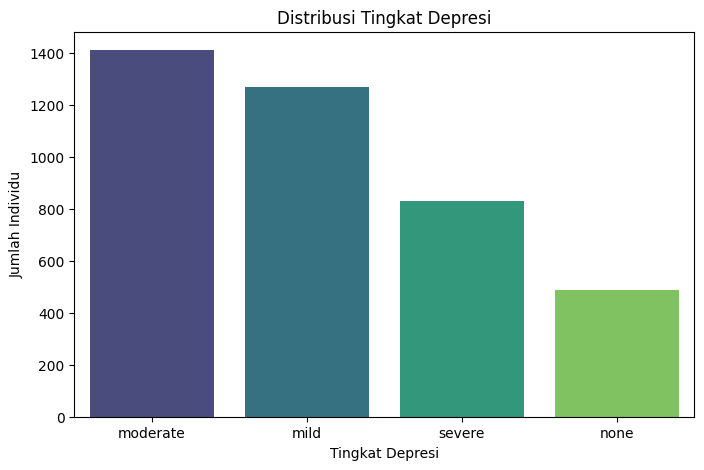

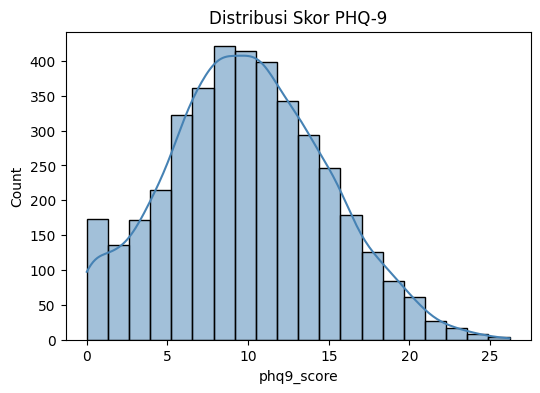

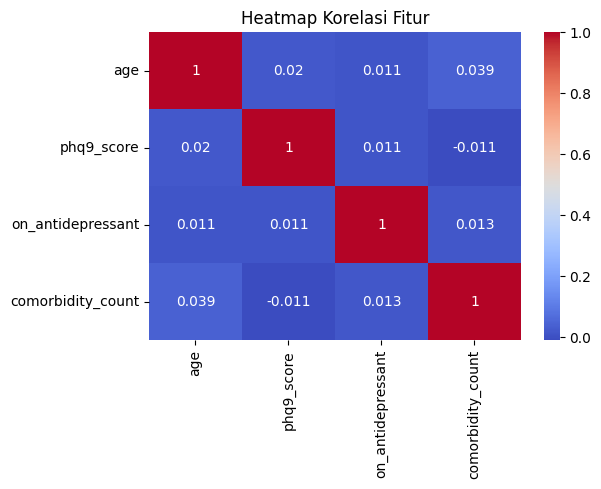

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='depression_level', hue='depression_level', data=df, palette='viridis', legend=False)
plt.title('Distribusi Tingkat Depresi')
plt.xlabel('Tingkat Depresi')
plt.ylabel('Jumlah Individu')
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['phq9_score'], bins=20, kde=True, color='steelblue')
plt.title('Distribusi Skor PHQ-9')
plt.show()

corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

X = df[['age','phq9_score','on_antidepressant','comorbidity_count','sex']]
X = pd.get_dummies(X, drop_first=True)  # one-hot encoding gender
y = df['depression_level']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train[X.columns] = scaler.fit_transform(X_train[X.columns])
X_test[X.columns] = scaler.transform(X_test[X.columns])


SVM Results:
              precision    recall  f1-score   support

        mild       0.95      0.98      0.96       254
    moderate       0.97      0.96      0.96       282
        none       0.99      0.95      0.97        98
      severe       0.98      0.98      0.98       166

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800


Naive Bayes Results:
              precision    recall  f1-score   support

        mild       0.99      1.00      0.99       254
    moderate       1.00      1.00      1.00       282
        none       0.99      0.98      0.98        98
      severe       1.00      1.00      1.00       166

    accuracy                           1.00       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      1.00      1.00       800


KNN Results:
              precision    recall  f1-score   support

        mild       0.92  

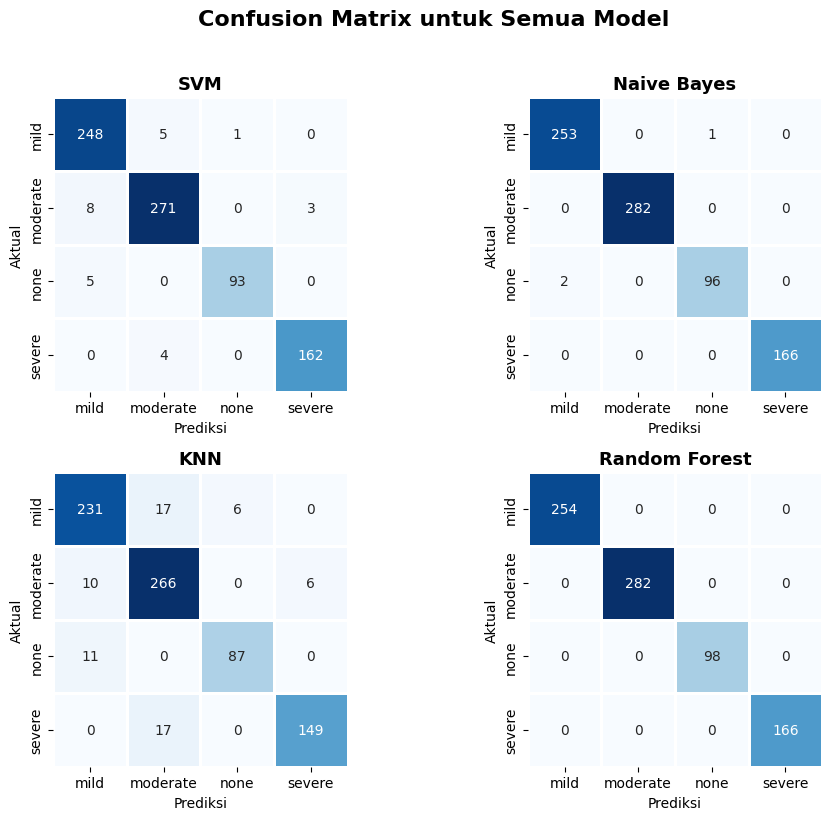

,Model,Accuracy,F1
0,SVM,0.968,0.968
1,Naive Bayes,0.996,0.996
2,KNN,0.916,0.916
3,Random Forest,1.000,1.000


In [6]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# Inisialisasi Model
# ==============================
models = {
    'SVM': SVC(kernel='rbf', C=2, gamma='auto'),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42)
}

results = []
conf_matrices = {}

# ==============================
# Pelatihan dan Evaluasi
# ==============================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({'Model': name, 'Accuracy': acc, 'F1': f1})

    # Simpan confusion matrix untuk plot bersama
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# ==============================
# Visualisasi Confusion Matrix 2x2
# ==============================
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    sns.heatmap(
        cm_df, annot=True, fmt='d', cmap='Blues',
        cbar=False, square=True, linewidths=1, linecolor='white', ax=ax
    )
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Prediksi')
    ax.set_ylabel('Aktual')

plt.suptitle('Confusion Matrix untuk Semua Model', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ==============================
# Ringkasan Akurasi & F1-Score
# ==============================
res_df = pd.DataFrame(results)
display(
    res_df.style
    .background_gradient(cmap='Blues')
    .format({'Accuracy': '{:.3f}', 'F1': '{:.3f}'})
    .set_caption("Hasil Evaluasi Model Deteksi Depresi")
)

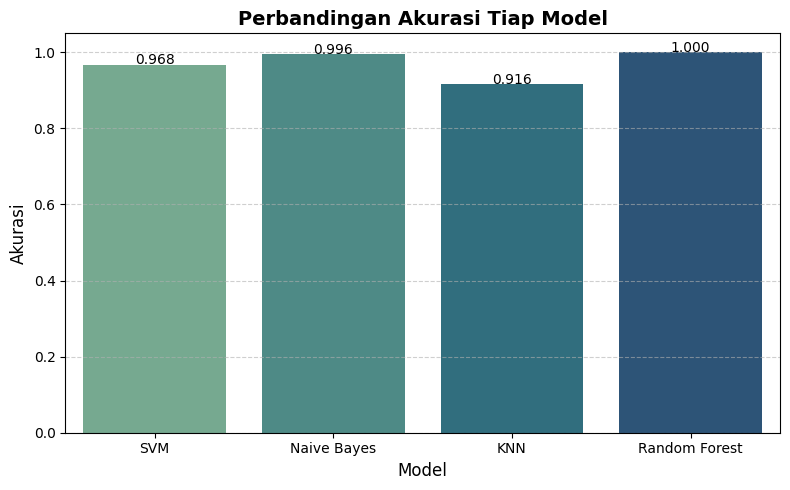

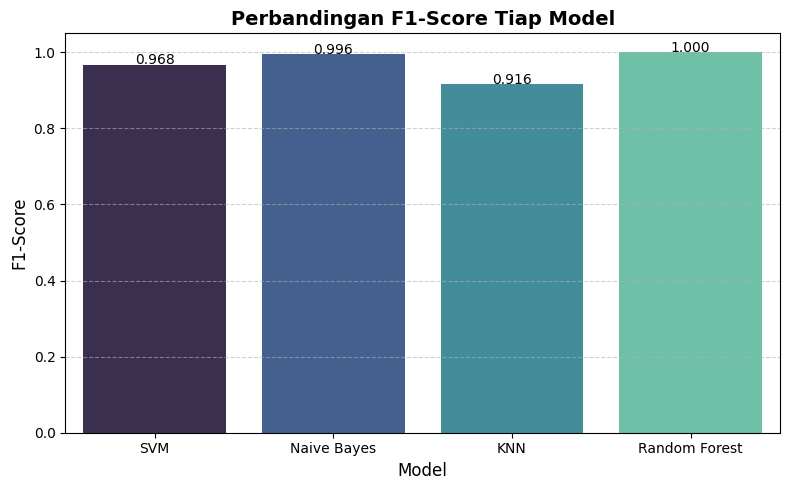

,Model,Accuracy,F1
0,SVM,0.968,0.968
1,Naive Bayes,0.996,0.996
2,KNN,0.916,0.916
3,Random Forest,1.000,1.000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Membuat DataFrame hasil evaluasi
res_df = pd.DataFrame(results)

# ======== Diagram Akurasi ========
plt.figure(figsize=(8,5))
ax1 = sns.barplot(
    x='Model', y='Accuracy', hue='Model',
    data=res_df, palette='crest', legend=False
)
plt.title('Perbandingan Akurasi Tiap Model', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Hitung batas atas + sedikit ruang (5%)
ymax_acc = res_df['Accuracy'].max()
plt.ylim(0, ymax_acc + 0.05)

# Tambahkan label di atas batang dengan sedikit jarak
for container in ax1.containers:
    ax1.bar_label(
        container,
        fmt='%.3f',
        label_type='edge',
        fontsize=10,
        color='black',
        padding=-2  # turunkan label sedikit biar tidak menabrak garis
    )

plt.tight_layout()
plt.show()

# ======== Diagram F1-Score ========
plt.figure(figsize=(8,5))
ax2 = sns.barplot(
    x='Model', y='F1', hue='Model',
    data=res_df, palette='mako', legend=False
)
plt.title('Perbandingan F1-Score Tiap Model', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Hitung batas atas + ruang ekstra
ymax_f1 = res_df['F1'].max()
plt.ylim(0, ymax_f1 + 0.05)

# Tambahkan label nilai di atas batang dengan jarak aman
for container in ax2.containers:
    ax2.bar_label(
        container,
        fmt='%.3f',
        label_type='edge',
        fontsize=10,
        color='black',
        padding=-2
    )

plt.tight_layout()
plt.show()

# ======== Tabel Hasil ========
display(
    res_df.style
    .background_gradient(cmap='Blues')
    .format({'Accuracy': '{:.3f}', 'F1': '{:.3f}'})
    .set_caption("Hasil Evaluasi Model Deteksi Depresi")
)

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RandomForestClassifier(n_estimators=300, random_state=42),
                         X, y, cv=5, scoring='accuracy')
print("Akurasi cross-validation:", scores)
print("Rata-rata:", scores.mean())

Akurasi cross-validation: [0.99875 0.99875 0.99875 1.      0.99875]
Rata-rata: 0.999


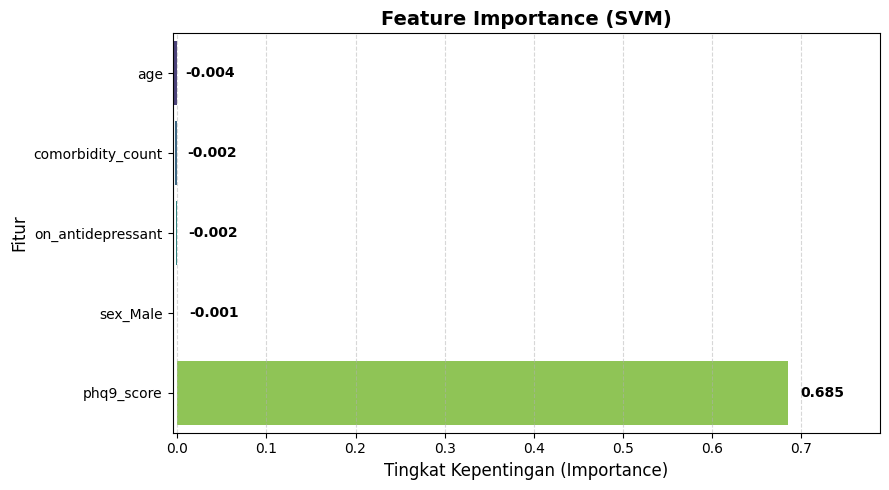

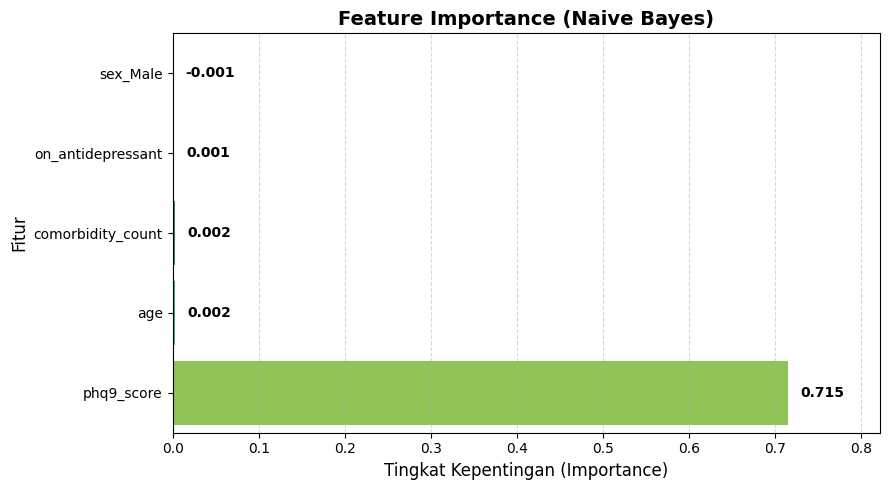

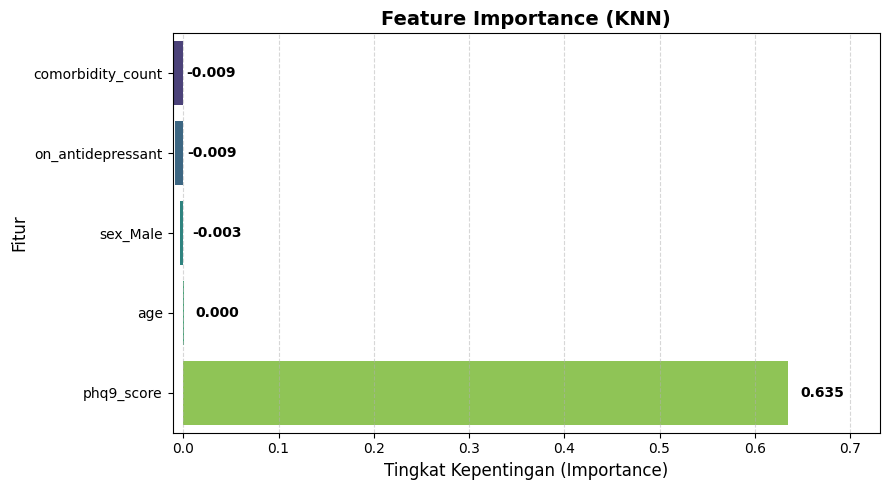

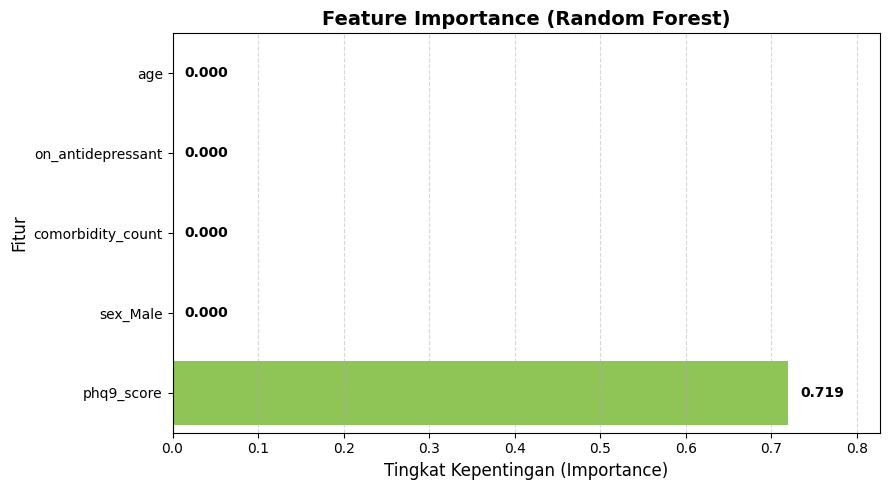

In [9]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loop tiap model dan tampilkan feature importance
for name, model in models.items():
    model.fit(X_train, y_train)

    # Hitung permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # DataFrame importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    }).sort_values(by='Importance', ascending=True)

    # Plot
    plt.figure(figsize=(9,5))
    ax = sns.barplot(
        x='Importance',
        y='Feature',
        hue='Feature',                # tambahkan hue
        data=importance_df,
        palette='viridis',
        legend=False                  # sembunyikan legend
    )

    plt.title(f'Feature Importance ({name})', fontsize=14, fontweight='bold')
    plt.xlabel('Tingkat Kepentingan (Importance)', fontsize=12)
    plt.ylabel('Fitur', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Tambahkan ruang kanan
    min_val = importance_df['Importance'].min()
    max_val = importance_df['Importance'].max()
    margin = (max_val - min_val) * 0.15
    plt.xlim(min_val - abs(min_val)*0.2, max_val + margin)

    # Label angka di luar batang
    for i, (val, feature) in enumerate(zip(importance_df['Importance'], importance_df['Feature'])):
        ax.text(
            val + (max_val * 0.02),
            i,
            f"{val:.3f}",
            color='black',
            ha='left', va='center',
            fontsize=10, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()